Sweet!
===
01 Gave us a few tools which seem useful in analyzing sound. To encode the sound, lets break up the file into small samples. Small enough that we can focus on only voice/unvoiced/silent utterances, but large enough that low frequencies can be recorded and noticed.

[transfer url](http://stevemorphet.weebly.com/speech-and-audio-processing.html)

First, lets get the imports setup

In [1]:
# Imports
import matplotlib
matplotlib.use('nbagg')

import IPython
from matplotlib.mlab import find
import matplotlib.pyplot as plt

import wave
import struct
import numpy as np
import math
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy.signal import blackmanharris, fftconvolve
from aubio import source, pitch

Next, lets wrap everything up into just a few nice/clean functions

In [2]:
def sampProfile(sig, fs):
    # get RMS
    ms = [(abs(i) ** 2)/float(len(sig)) for i in sig]
    rms = np.sqrt(sum(ms))/float(len(sig))
    
    # get max amplitude
    maxAmp = max(max(sig), abs(min(sig)))
    
    # get Zero Crossings
    zero_crossings = 0
    last_val = sig[0]
    for i in range(1,len(sig)):
        if last_val > 0 and sig[i] < 0:
            zero_crossings +=1
        elif last_val < 0 and sig[i] > 0:
            zero_crossings += 1
        last_val = sig[i]
        
    # get Fundamental Frequency
    win_s = len(sig)
    pitch_o = pitch('yin', win_s, win_s, fs)
    sig_for_pitch = np.array(sig).astype(np.float32) #recast type
    fund_freq = pitch_o(sig_for_pitch)[0]
    
    return [rms, maxAmp, zero_crossings, fund_freq]

In [3]:
samples = ["aaa.wav", "k.wav", "sea.wav", "noVoice.wav", "200sine.wav", "hello_world.wav"]


# In seconds:
targetWindow = .2
# In % of sampSize
targetStep = .5

decodeBloc = []

for fil in samples:
    print "\n",fil
    fs, sig = wavfile.read(fil)
    try:
        if len(sig[0]) > 1:
            sig1, sig2 = zip(*sig)
            sig = sig1
            
    except:
        pass
    sampSize = int(2**math.ceil(np.log2(fs*targetWindow)))
    sampEnc = []
    print "Sample index | RMS | maxAmp | zero crossing | Fundamental Freq"
    for i in range(0,len(sig)-sampSize,sampSize/2):
        vals = sampProfile(sig[i:i+sampSize], fs)
        
        sampEnc.append([i]+vals)
        print i, vals
    decodeBloc.append([fil, len(sig), sampEnc])  
    
    
        


aaa.wav
Sample index | RMS | maxAmp | zero crossing | Fundamental Freq
0 [1.1295429418574874, 8925, 357, 108.9625]
1024 [1.5167635476446082, 8925, 473, 34.448311]
2048

/home/keith/anaconda2/lib/python2.7/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


 [1.4822408297176703, 7935, 478, 105.93098]
3072 [1.4699140905114056, 7112, 482, 105.90034]
4096 [1.390225277419012, 7112, 472, 104.99764]
5120 [1.2896375457220546, 6563, 470, 106.17836]
6144 [1.4723511008645438, 8675, 484, 105.46782]
7168 [1.4380924489093947, 8675, 481, 105.47495]
8192 [1.3368527736749789, 6525, 480, 104.50325]
9216 [1.1072954290894628, 6525, 408, 105.26958]
10240 [0.50822192958307633, 6409, 231, 992.28986]

k.wav
Sample index | RMS | maxAmp | zero crossing | Fundamental Freq
0 [0.960386451826301, 9651, 804, 2030.2511]
1024 [0.57944611606744179, 7441, 667, 1975.0597]
2048 [0.24607424691855079, 2423, 299, 8.1683083]

sea.wav
Sample index | RMS | maxAmp | zero crossing | Fundamental Freq
0 [1.7865129530884603, 13114, 225, 144.21259]
1024 [1.4522927089275812, 9742, 202, 136.28589]
2048 [0.57553808815859053, 4713, 153, 98.604202]
3072 [0.28143073647469347, 2261, 103, 89.169228]

noVoice.wav
Sample index | RMS | maxAmp | zero crossing | Fundamental Freq
0 [0.49369967370045

Well that's ... neat.
---

Ok so when we decode, we'll want to take whatever inputs we are handed, and reconstruct the sig accordingly

If we fed it useful values, the reconstruction will sound ...similar and hopefully understandable. 

This crude setup currently uses 4 values to reconstruct the next 2048 samples, with a step of 1024 samples . 


So lets hash out what we're going to need

>if the signal has an rms > rms_thresh then it's a produced sound

>>  if then that signal has zero crossings < zc_thres, it's a voiced sound, use the fund freq
  
>>  else produce random noise at rms values
  
>else use 'silent' noise


Ok cool, that should give us a framework to move forward from. If it doesn't produce a nice sound, it should at least produce a sound we can improve specifics on
  

6
['aaa.wav', 12446, [[0, 1.1295429418574874, 8925, 357, 108.9625], [1024, 1.5167635476446082, 8925, 473, 34.448311], [2048, 1.4822408297176703, 7935, 478, 105.93098], [3072, 1.4699140905114056, 7112, 482, 105.90034], [4096, 1.390225277419012, 7112, 472, 104.99764], [5120, 1.2896375457220546, 6563, 470, 106.17836], [6144, 1.4723511008645438, 8675, 484, 105.46782], [7168, 1.4380924489093947, 8675, 481, 105.47495], [8192, 1.3368527736749789, 6525, 480, 104.50325], [9216, 1.1072954290894628, 6525, 408, 105.26958], [10240, 0.50822192958307633, 6409, 231, 992.28986]]]
2048
aaa.wav
12446
11 [0, 1.1295429418574874, 8925, 357, 108.9625]
fl


<IPython.core.display.Javascript object>


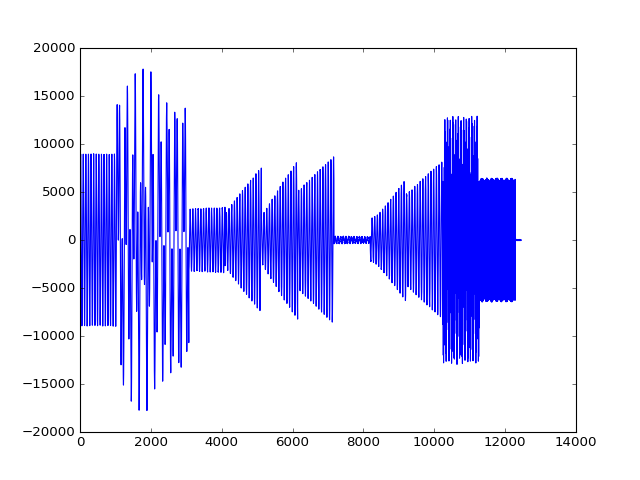

k.wav
5016
3 [0, 0.960386451826301, 9651, 804, 2030.2511]
fl


<IPython.core.display.Javascript object>


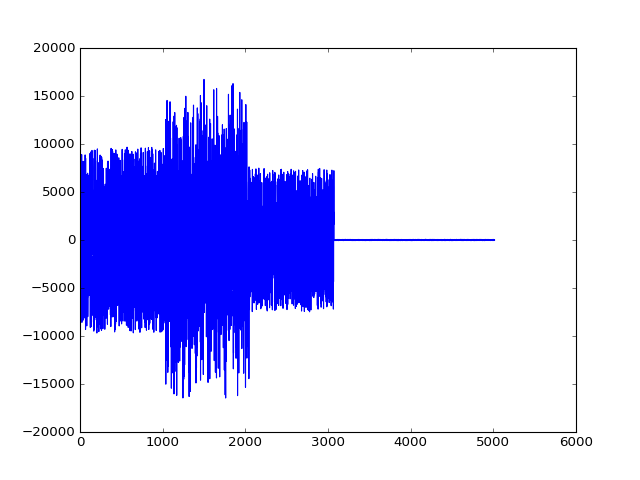

sea.wav
5851
4 [0, 1.7865129530884603, 13114, 225, 144.21259]
fl


<IPython.core.display.Javascript object>


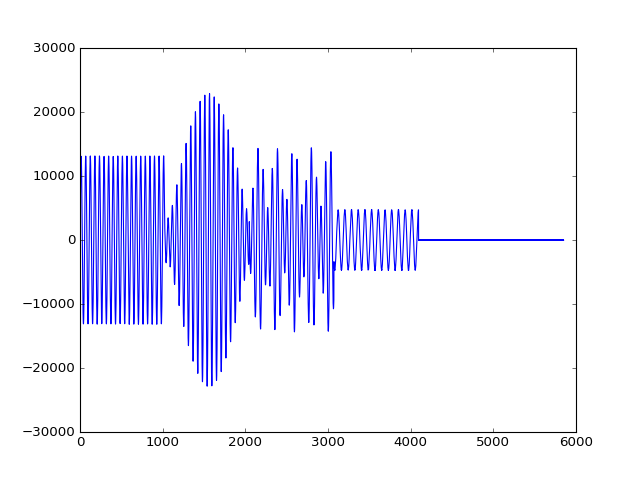

noVoice.wav
17554
16 [0, 0.49369967370045992, 3465, 185, 19.635672]
fl


<IPython.core.display.Javascript object>


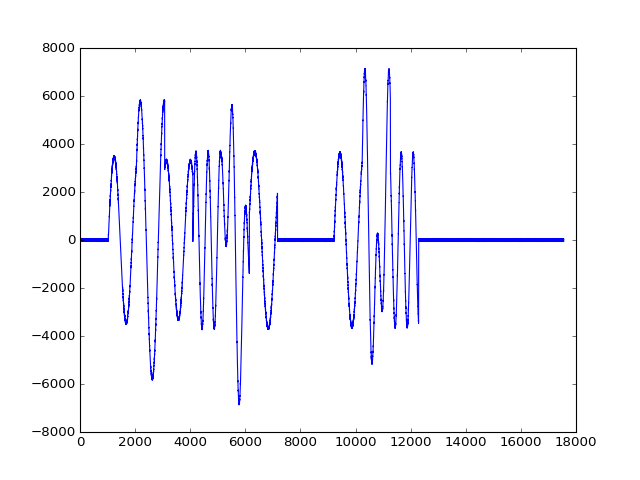

200sine.wav
22626
21 [0, 1.3180339767077653, 6057, 108, 200.30357]
fl


<IPython.core.display.Javascript object>


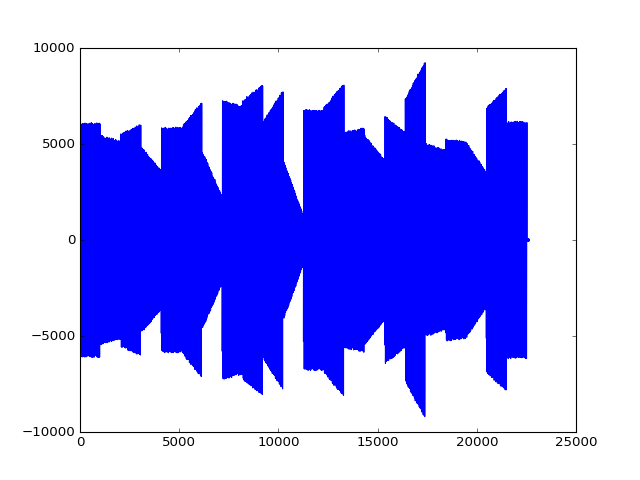

hello_world.wav
13746
12 [0, 0.097105071183620773, 655, 272, 9.1285219]
fl


<IPython.core.display.Javascript object>


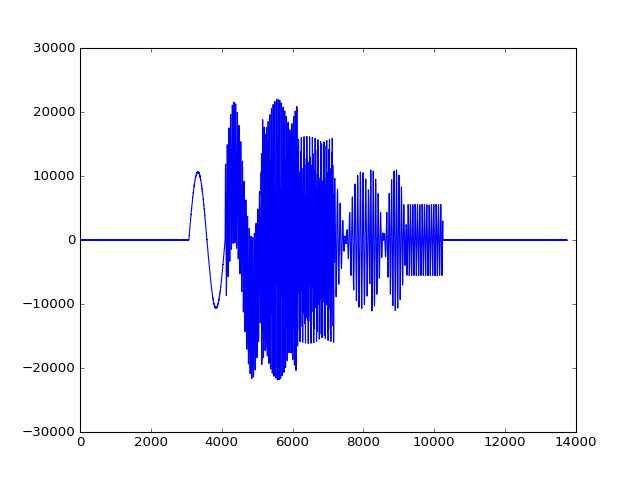

In [22]:
print len(decodeBloc)
print decodeBloc[0]

rms_thresh = 0.5
zc_thresh = 500
silent_noise = 0.2

samp_len = sampSize
print samp_len

#error here to stop code below :P

# Encodings key
# 0:Sample index |1: RMS |2: maxAmp |3: zero crossing |4: Fundamental Freq


for i in range(len(decodeBloc)):
    fl, sigLen, encodings = decodeBloc[i]
    
    print fl
    print sigLen
    print len(encodings), encodings[0]
    
    outSig = np.random.uniform(-0.002, 0.002, sigLen)
    
    for j in range(len(encodings)):
        #print len(encodings[j])
        sampIndex, rms, maxAmp, zcCount, fundFreq = encodings[j]
        sampLen = 2048
        if rms > rms_thresh:
            # It's a produced noise
            if zcCount < zc_thresh:
                # It's a voiced noise
                # Get Normalized amplitude
                newAmp = maxAmp /float(32767) # Since we'll use 16 bit with 15 bit + sign 
                t = np.linspace(0,sampLen/float(fs),sampLen)
                voicedSig = newAmp * np.sin(2*np.pi*fundFreq * t)
                #print max(voicedSig), min(voicedSig)
                #print len(voicedSig)
                outSig[sampIndex:sampIndex+sampLen] += voicedSig
            else:
                # It's not voiced, random noise
                noiseRange = maxAmp/float(32767)
                unVsig = np.random.uniform(-noiseRange, noiseRange, sampLen)
                outSig[sampIndex:sampIndex+sampLen] += unVsig
        
    scaled = np.int16(outSig * 32767)
    wavfile.write('OUT'+fl, fs, scaled)
    print "fl"
    plt.plot(scaled)
    plt.show()